# Example: Gol, Lazar and Belta (2013)

This example reproduces parts of the numerical results of [3]. A similar example reproducing all results of [3] is available as a codeocean capsule in [4].

This example was borrowed from [1, Example VIII.A] and tackles
an optimal control for the hybrid system with state evolution governed by
$$
x(k+1) = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}x(k) + \begin{bmatrix} 0.5 \\ 1.0 \end{bmatrix} u(k)
$$

The goal is to take the state vector toward a target set **XT** by visiting one of the squares
**A** or **B** and avoiding the obstacles **O1** and **O2**

First, let us import [CDDLib](https://github.com/JuliaPolyhedra/CDDLib.jl),
[GLPK](https://github.com/jump-dev/GLPK.jl), [OSQP](https://github.com/oxfordcontrol/OSQP.jl),
[JuMP](https://github.com/jump-dev/JuMP.jl), [Pavito](https://github.com/jump-dev/Pavito.jl)
and [Ipopt](https://github.com/jump-dev/Ipopt.jl)

In [1]:
import CDDLib
import GLPK
import OSQP
using JuMP
import Pavito
import Cbc
import Ipopt

At this point we import Dionysos

In [2]:
using Dionysos

And the file defining the hybrid system for this problem

In [3]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "examples", "gol_lazar_belta.jl"))

gol_lazar_belta (generic function with 1 method)

Now we instantiate our system using the function provided by [gol\_lazar\_belta.jl](https://github.com/dionysos-dev/Dionysos.jl/blob/master/examples/gol_lazar_belta.jl)

In [4]:
system = gol_lazar_belta(CDDLib.Library(), Float64);

Then, we define initial conditions (continuous and discrete states) to this system
and set `N` as the search depth, i.e., the number of allowed time steps.

In [5]:
x0 = [1.0, -6.0];
q0 = 3;

N = 11;

We instantiate our Optimal Control Problem by defining the state and transition costs.
Notice that Comment that `state_cost` is defined to be zero for each mode/discrete state
of the system and the `transition_cost` is defined to be `u_1^2` which is defined by the
quadratic form `u' * Q * u` with `Q = ones(1, 1)`.

In [6]:
state_cost = Fill(ZeroFunction(), nmodes(system))
transition_cost = QuadraticControlFunction(ones(1, 1))

problem = OptimalControlProblem(
    system,
    q0, x0,
    Fill(state_cost, N),
    Fill(Fill(transition_cost, ntransitions(system)), N),
    system.ext[:q_T],
    N
);

Notice that we used `Fill` for all `N` time steps as we consider time-invariant costs.
Finally, we select the method presented in [2] as our optimizer

In [7]:
qp_solver = optimizer_with_attributes(
    OSQP.Optimizer,
    "eps_abs" => 1e-8,
    "eps_rel" => 1e-8,
    "max_iter" => 100000,
    MOI.Silent() => true
);

mip_solver = optimizer_with_attributes(
    Cbc.Optimizer,
    MOI.Silent() => true
);

cont_solver = optimizer_with_attributes(
    Ipopt.Optimizer,
    MOI.Silent() => true
);

miqp_solver = optimizer_with_attributes(
    Pavito.Optimizer,
    "mip_solver" => mip_solver,
    "cont_solver" => cont_solver,
    MOI.Silent() => true
);


algo = optimizer_with_attributes(BemporadMorari.Optimizer{Float64},
    "continuous_solver" => qp_solver,
    "mixed_integer_solver" => miqp_solver,
    "indicator" => false,
    "log_level" => 0
);

and use it to solve the given problem, with the help of the abstraction layer
MathOptInterface provided by [JuMP](https://github.com/jump-dev/JuMP.jl)

In [8]:
optimizer = MOI.instantiate(algo)
MOI.set(optimizer, MOI.RawParameter("problem"), problem)
MOI.optimize!(optimizer)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

┌ Warning: Infeasible NLP problem terminated with primal status: NEARLY_FEASIBLE_POINT. This cannot be as this NLP problem was feasible by design.
└ @ Pavito /home/runner/.julia/packages/Pavito/H744k/src/algorithm.jl:428


We check the solver time

In [9]:
MOI.get(optimizer, MOI.SolveTime())

7.887601852416992

the termination status

In [10]:
termination = MOI.get(optimizer, MOI.TerminationStatus())

OPTIMAL::TerminationStatusCode = 1

the objective value

In [11]:
objective_value = MOI.get(optimizer, MOI.ObjectiveValue())

11.385062952226304

and recover the corresponding continuous trajectory

In [12]:
xu = MOI.get(optimizer, ContinuousTrajectoryAttribute());

A little bit of data visualization now:

glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to recover undefined or non-optimal solution
glp_simplex: unable to re

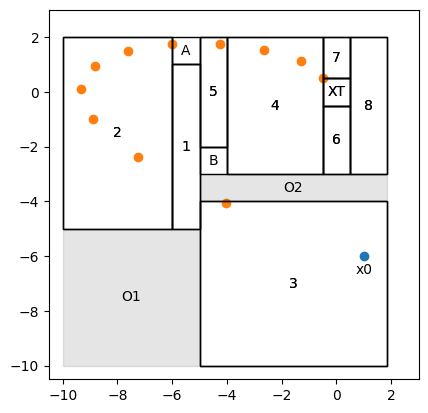

In [13]:
using PyPlot
using Colors

##Auxiliary function for annotating
function text_in_set_plot!(ax, po, t;  fillcolor = :white, linecolor = :black, fillalpha = 1)
    ##solve finding center (other solvers? https://jump.dev/JuMP.jl/dev/installation/#Supported-solvers)
    solver = optimizer_with_attributes(GLPK.Optimizer, "presolve" => GLPK.ON)
    poly = matplotlib.patches.Polygon(get_ordered_vertices(po))
    poly.set_facecolor(fillcolor)
    poly.set_edgecolor(linecolor)
    poly.set_alpha(fillalpha)
    ax.add_patch(poly)

    if t !== nothing
        c, r = hchebyshevcenter(hrep(po), solver, verbose=0)
        ax.annotate(t, c, ha="center", va="center")
    end
end

##Initialize our canvas
fig = PyPlot.figure()

ax = PyPlot.axes(aspect = "equal")
ax.set_xlim(-10.5,3)
ax.set_ylim(-10.5,3)

##Show the discrete modes
for mode in states(system)
    t = (system.ext[:q_T] in [mode, mode + 11]) ? "XT" : (mode == system.ext[:q_A] ? "A" : (mode == system.ext[:q_B] ? "B" :
            mode <= 11 ? string(mode) : string(mode - 11)))
    text_in_set_plot!(ax, stateset(system, mode), t, fillcolor = "none", linecolor = :black)
end

##Plot obstacles
for i in eachindex(system.ext[:obstacles])
    text_in_set_plot!(ax, system.ext[:obstacles][i], "O$i", fillcolor = :black, fillalpha = 0.1)
end


##Initial state
ax.scatter([x0[1]], [x0[2]])
ax.annotate("x0", [x0[1], x0[2]-0.5], ha="center", va="center")

##Split the vector into x1 and x2
x1 = [xu.x[j][1] for j in eachindex(xu.x)]
x2 = [xu.x[j][2] for j in eachindex(xu.x)]

##Plot the trajectory
ax.scatter(x1, x2)
gcf()

### References

1. Gol, E. A., Lazar, M., & Belta, C. (2013). Language-guided controller synthesis for linear systems. IEEE Transactions on Automatic Control, 59(5), 1163-1176.
1. Bemporad, A., & Morari, M. (1999). Control of systems integrating logic, dynamics, and constraints. Automatica, 35(3), 407-427.
1. Legat B., Bouchat J., Jungers R. M. (2021). Abstraction-based branch and bound approach to Q-learning for hybrid optimal control. 3rd Annual Learning for Dynamics & Control Conference, 2021.
1. Legat B., Bouchat J., Jungers R. M. (2021). Abstraction-based branch and bound approach to Q-learning for hybrid optimal control. https://www.codeocean.com/. https://doi.org/10.24433/CO.6650697.v1.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*